In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Bidirectional, Concatenate, AdditiveAttention, Attention, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Read the Data and Create DF

In [2]:
text = open('data/pol.txt').read().split('\n')
print(len(text))

41179


In [3]:
language_df = pd.DataFrame(columns=['en', 'pl'])
en_list = []
pl_list = []
for sentences in text:
  try:
    sentence = sentences.split('\t')
    pl_list.append(sentence[1])
    en_list.append(sentence[0])
  except: 
    continue

language_df['en'] = en_list
language_df['pl'] = pl_list
language_df.sample(20)

,en,pl
40455,"Considering what time it was, the supermarket ...","Biorąc pod uwagę, jaka była pora, w supermarke..."
41021,"I don't know exactly where I left my keys, but...","Nie wiem, gdzie dokładnie zostawiłem moje kluc..."
38444,My car was stolen. It's no longer where I park...,"Ukradziono mi samochód. Nie ma go tam, gdzie z..."
27197,Everything went according to plan.,Wszystko szło zgodnie z planem.
25747,Tom's hands are behind his back.,Ręce Toma są za jego plecami.
20013,Nobody here ordered a pizza.,Nikt tutaj nie zamawiał pizzy.
15031,Do you want some raisins?,Chcesz trochę rodzynek?
34560,Tom donated three paintings to the museum.,Tom podarował muzeum trzy obrazy.
32212,"I said to myself, ""That's a good idea.""",Powiedziałem sobie: to dobry pomysł.
10691,I have an explanation.,Mam wyjaśnienie


# Data Cleaning

In [4]:
def clean_text(text):
    # to lower case and remove spaces and end and start
    text = text.lower().strip()
    # remove digits
    text = re.sub('\d', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

language_df['en'] = language_df['en'].apply(clean_text)
language_df['pl'] = language_df['pl'].apply(clean_text)
language_df.sample(20)

,en,pl
30849,tom and mary werent speaking french,tom i mary nie mówili po francusku
22696,luckily the weather was good,na szczęście pogoda była ładna
12794,she shaved her armpits,ogoliła sobie pachy
28255,i didnt get exactly what i wanted,dostałam nie do końca to czego chciałam
30165,why didnt you say something to tom,dlaczego nie zwróciłeś uwagi tomowi
36560,the man sitting over there is a famous singer,człowiek który tam siedzi to słynny śpiewak
92,come in,wchodź
26696,there are limits to my knowledge,o ile wiem nie ma ograniczeń
34847,i cant figure out how to solve the puzzle,nie mogę odkryć jak rozwiązać zagadkę
30791,the ship will arrive by five oclock,ten statek przypłynie o piątej o siedemnastej


In [5]:
# putting START and END in polish sentences
language_df['pl'] = language_df['pl'].apply(lambda text: "[START] "+text+" [END]")
print("English Sentence: " + language_df['en'].iloc[55])
print("Polish Sentence: " + language_df['pl'].iloc[55])

English Sentence: he ran
Polish Sentence: [START] on pobiegł [END]


# Data Preparation for Model Building

In [6]:
import numpy as np

# train test split
x = language_df['en']
y = language_df['pl']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)



In [7]:
def determine_sentence_len(data):
    lenghts = [len(x.split(' ')) for x in data]
    return max(lenghts)
max_len_en = determine_sentence_len(x_train)
max_len_pl = determine_sentence_len(y_train)
max_len_en, max_len_pl

(47, 40)

In [8]:
# Tokenization
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(x_train)
en_word2index = en_tokenizer.word_index
vocab_size_en = len(en_word2index) + 1

x_train = en_tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=max_len_en, padding='post')
x_test = en_tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen = max_len_en, padding='post')

pl_tokenizer = Tokenizer()
pl_tokenizer.fit_on_texts(y_train)
pl_word2index = pl_tokenizer.word_index
vocab_size_pl = len(pl_word2index) + 1

y_train = pl_tokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_len_pl, padding='post')
y_test = pl_tokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_len_pl, padding='post')

vocab_size_en, vocab_size_pl

(8040, 20313)

In [9]:
print(pl_word2index)

{'start': 1, 'end': 2, 'nie': 3, 'tom': 4, 'się': 5, 'to': 6, 'jest': 7, 'w': 8, 'że': 9, 'na': 10, 'do': 11, 'z': 12, 'co': 13, 'czy': 14, 'jak': 15, 'mary': 16, 'mi': 17, 'o': 18, 'mnie': 19, 'i': 20, 'tego': 21, 'jestem': 22, 'jesteś': 23, 'po': 24, 'toma': 25, 'ma': 26, 'za': 27, 'był': 28, 'on': 29, 'mam': 30, 'ci': 31, 'bardzo': 32, 'tym': 33, 'tak': 34, 'mogę': 35, 'już': 36, 'są': 37, 'zrobić': 38, 'ten': 39, 'chcę': 40, 'żeby': 41, 'tu': 42, 'cię': 43, 'domu': 44, 'nigdy': 45, 'być': 46, 'może': 47, 'od': 48, 'kiedy': 49, 'będzie': 50, 'powiedział': 51, 'wiem': 52, 'gdzie': 53, 'ona': 54, 'coś': 55, 'mój': 56, 'tomowi': 57, 'dla': 58, 'było': 59, 'tylko': 60, 'go': 61, 'jego': 62, 'masz': 63, 'dlaczego': 64, 'jeszcze': 65, 'teraz': 66, 'myślę': 67, 'kto': 68, 'wszystko': 69, 'przez': 70, 'chcesz': 71, 'nic': 72, 'proszę': 73, 'ale': 74, 'naprawdę': 75, 'możesz': 76, 'tam': 77, 'muszę': 78, 'iść': 79, 'ze': 80, 'chciałbym': 81, 'sobie': 82, 'chce': 83, 'jej': 84, 'dobrze': 85, 

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train[0], y_train[0]

(array([   5,  169, 1068,  340,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=int32),
 array([   1,  125,    5, 4866,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int32))

# Define Model

## Encoder

In [11]:
# Encoder input
encoder_inputs = Input(shape=(max_len_en,)) 

# Embedding layer- i am using 1024 output-dim for embedding you can try diff values 100,256,512,1000
enc_emb = Embedding(vocab_size_en, 300)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

# Concatenate both h and c 
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# get Context vector
encoder_states =[final_enc_h, final_enc_c]

## Decoder

In [12]:
#  decoder input
decoder_inputs = Input(shape=(None,)) 

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(vocab_size_pl, 300) 
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction 

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = AdditiveAttention()
attention_result = attention_layer([decoder_outputs, encoder_outputs1])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(vocab_size_pl, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

## Define Model

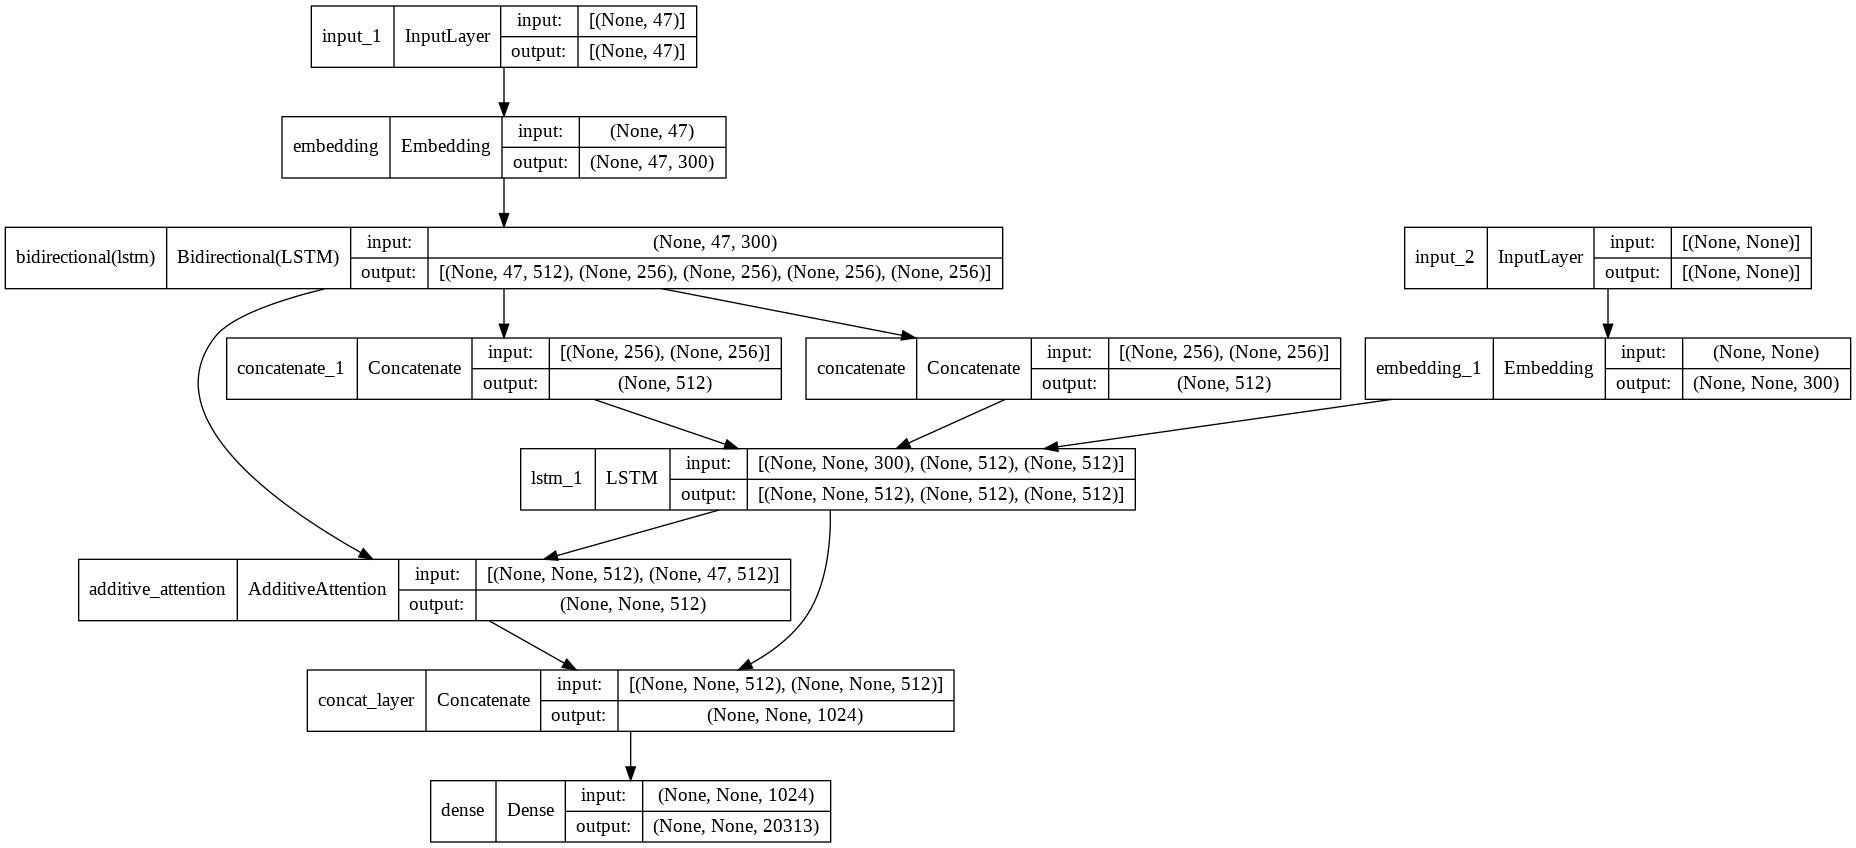

In [13]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 47, 300)      2412000     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 47, 512),    1140736     ['embedding[0][0]']              
                                 (None, 256),                                                 

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [early_stopping]
# Training set
encoder_input_data = x_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# devlopment set
encoder_input_test = x_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

EPOCHS= 50 
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    epochs=50, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

# Don't forget to save weights of trained model 
model.save_weights("model.h5") # can give whole path to save model

Epoch 1/50
290/290 [==============================] - 179s 585ms/step - loss: 1.0397 - accuracy: 0.8728 - val_loss: 0.7817 - val_accuracy: 0.8920
Epoch 2/50
290/290 [==============================] - 166s 573ms/step - loss: 0.7964 - accuracy: 0.8918 - val_loss: 0.6857 - val_accuracy: 0.9023
Epoch 3/50
290/290 [==============================] - 166s 574ms/step - loss: 0.6972 - accuracy: 0.9024 - val_loss: 0.6271 - val_accuracy: 0.9096
Epoch 4/50
290/290 [==============================] - 166s 572ms/step - loss: 0.6195 - accuracy: 0.9107 - val_loss: 0.5747 - val_accuracy: 0.9159
Epoch 5/50
290/290 [==============================] - 167s 575ms/step - loss: 0.5576 - accuracy: 0.9175 - val_loss: 0.5441 - val_accuracy: 0.9196
Epoch 6/50
290/290 [==============================] - 167s 576ms/step - loss: 0.5059 - accuracy: 0.9236 - val_loss: 0.5237 - val_accuracy: 0.9224
Epoch 7/50
290/290 [==============================] - 167s 576ms/step - loss: 0.4603 - accuracy: 0.9293 - val_loss: 0.5059 -

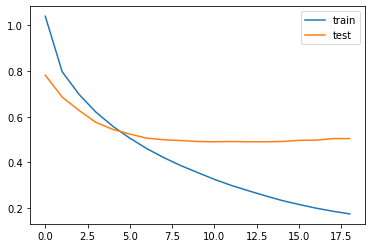

In [16]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Make a Predictions

In [17]:
# INFERENCE MODEL
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))

# we need hidden state for attention layer
# 36 is maximum length if english sentence It has to same as input taken by attention layer can see in model plot
decoder_hidden_state_input = Input(shape=(max_len_en, 512)) 
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer 
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf = attention_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
  
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = pl_word2index['start']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        sampled_char = pl_index2word[sampled_token_index]
        # aapend it to decoded sent
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'end' or len(decoded_sentence.split()) >= max_len_en):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        enc_h, enc_c = h, c
    
    return decoded_sentence

In [ ]:
en_index2word = en_tokenizer.index_word
pl_index2word = pl_tokenizer.index_word
def seq2summary(input_seq):
    new_string = ''
    for i in input_seq:
      if((i!=0 and i!=pl_word2index['start']) and i!=pl_word2index['end']):
        new_string += pl_index2word[i]+' '
    return new_string

def seq2text(input_seq):
    new_string=''
    for i in input_seq:
      if(i!=0):
        new_string += en_index2word[i]+' '
    return new_string

In [ ]:
for i in range(150, 155):  
  print("Review:",seq2text(x_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",get_predicted_sentence(x_test[i].reshape(1, max_len_en)))
  print("\n")

Review: youre 
Original summary: jesteś uprzedzony 
Predicted summary:  jesteś end


Review: i want to find out why tom hit mary 
Original summary: chcę się dowiedzieć dlaczego tom uderzył mary 
Predicted summary:  chcę się upewnić że tom uderzył mary end


Review: it rarely snows in this area 
Original summary: na tym terenie rzadko pada śnieg 
Predicted summary:  rzadko rzadko w tym jak się pływać end


Review: this is the last piece of cake 
Original summary: to ostatni kawałek ciasta 
Predicted summary:  to jest ostatni raz na głowie end


Review: where is your school 
Original summary: gdzie jest twoja szkoła 
Predicted summary:  gdzie jest twoja szkoła end




In [ ]:
model.save('model.h5')